In [1]:
from __future__ import print_function, division

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
from torchvision import transforms, models, datasets

import matplotlib.pyplot as plt
import time
import copy

In [2]:
import zipfile
import os


# !wget --no-check-certificate \
#     "https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip" \
#     -O "/tmp/plantdoc-cropped.zip"




--2023-04-17 17:37:51--  https://github.com/pratikkayal/PlantDoc-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/pratikkayal/PlantDoc-Dataset/zip/refs/heads/master [following]
--2023-04-17 17:37:51--  https://codeload.github.com/pratikkayal/PlantDoc-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/plantdoc-cropped.zip’

/tmp/plantdoc-cropp     [      <=>           ] 938.81M  22.3MB/s    in 42s     

2023-04-17 17:38:33 (22.5 MB/s) - ‘/tmp/plantdoc-cropped.zip’ saved [984413268]



In [3]:
# zip_ref = zipfile.ZipFile('/tmp/plantdoc-cropped.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
# zip_ref.close()

In [4]:
# print('Test set Bell pepper' , len(os.listdir('/tmp/PlantDoc-Dataset-master/test/Bell_pepper leaf')))
# print('Train set Corn Rust' , len(os.listdir('/tmp/PlantDoc-Dataset-master/train/Corn rust leaf')))

Test set Bell pepper 8
Train set Corn Rust 106


In [93]:
DATA_PATH = "/kaggle/input/cropped-bg/croppedbg"
TRAIN_DATA_PATH = "/kaggle/input/cropped-bg/croppedbg/Train"
TEST_DATA_PATH = "/kaggle/input/cropped-bg/croppedbg/Test"

In [175]:
IMG_SIZE = 232
CROP_SIZE = 224
#EPOCHS = 20
BATCH_SIZE = 8
#LEARNING_RATE = 0.004
# DATA_PATH = "/tmp/PlantDoc-Dataset-master/"
# TRAIN_DATA_PATH = "/tmp/PlantDoc-Dataset-master/train/"
# TEST_DATA_PATH = "/tmp/PlantDoc-Dataset-master/test/"
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [176]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
#                                              shuffle=True, num_workers=2)
#               for x in ['train', 'test']}

In [129]:
image_datasets['Test']

Dataset ImageFolder
    Number of datapoints: 447
    Root location: /kaggle/input/cropped-bg/croppedbg/Test
    StandardTransform
Transform: Compose(
               Resize(size=(232, 232), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [177]:
VALID_RATIO = 0.8

n_train_examples = int(len(image_datasets['Train']) * VALID_RATIO)
n_valid_examples = len(image_datasets['Train']) - n_train_examples

train_data, valid_data = data.random_split(image_datasets['Train'], 
                                           [n_train_examples, n_valid_examples])
test_data = image_datasets["Test"]

In [178]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 6202
Number of validation examples: 1551


In [179]:
print(f'Number of testing examples: {len(test_data)}')

Number of testing examples: 447


In [180]:
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [181]:
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [182]:
num_classes = len(class_names)
num_classes

28

In [183]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image  

In [184]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

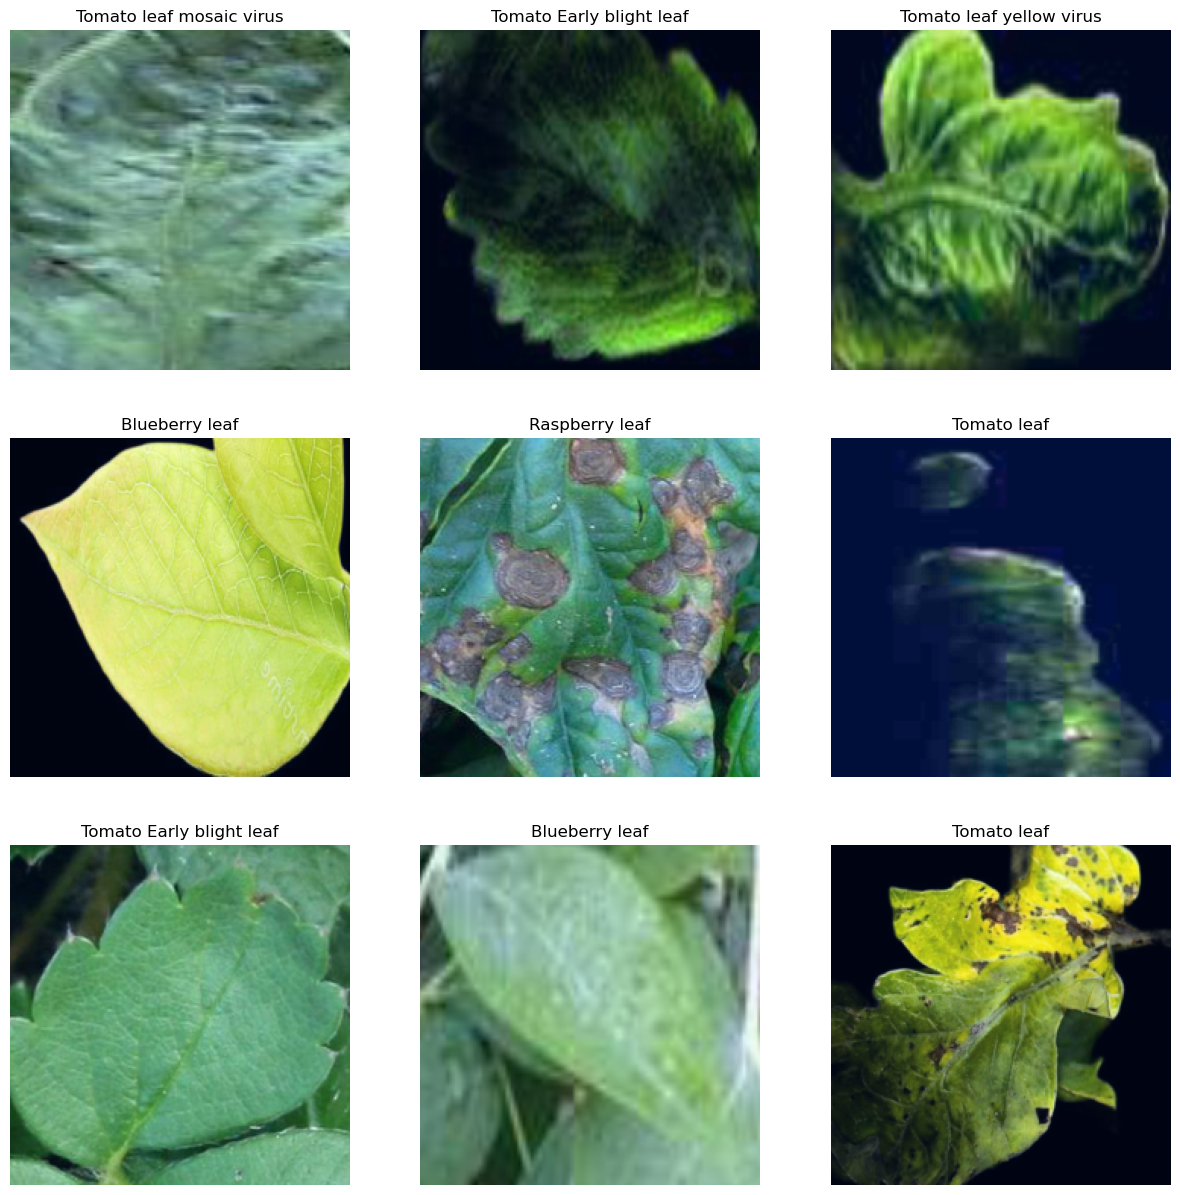

In [185]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [17]:
"""def imshow(inp, title=None):
    #Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #if title is not None:
    #    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, scale_each=True)

imshow(out, title=[class_names[x] for x in classes])"""

SyntaxError: invalid syntax (320930886.py, line 2)

In [109]:
from torch.utils.tensorboard import SummaryWriter

In [19]:
logdir = 'runs/plant_leaves'
writer = SummaryWriter(logdir)

In [110]:
PATIENCE = 2

In [ ]:
crop_sizes = {
    resnet50: 224,
}

In [187]:
from torchvision.models import resnet50, ResNet50_Weights

models = [torchvision.models.resnet50(weights = ResNet50_Weights.DEFAULT), 
          ]

In [ ]:
# models.mobilenet_v3_large(pretrained=True), 
#          models.vit_b_16(pretrained=True), 
#          torchvision.models.efficientnet_v2_s(pretrained=True)

In [188]:
model = models[0]
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [189]:
in_ft = model.fc.in_features
model.fc = nn.Linear(in_ft, num_classes)
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [190]:
last_conv_layer = model.layer4[2].conv3
print(last_conv_layer)

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [111]:
model_2 = models.vit_b_16(pretrained=True)

in_ft = model_2.heads.head.in_features
model_2.heads.head = nn.Linear(in_ft, num_classes)
model_2.to(device)

print(model_2)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [76]:
model1 = models.mobilenet_v3_large(pretrained=True)

in_ft = model1.classifier[-1].in_features
model1.classifier[-1] = nn.Linear(in_ft, num_classes)
model1.to(device)

last_conv_layer = model1.features[-1][0]

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [191]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,565,404 trainable parameters


In [192]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [193]:
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim.lr_scheduler as lr_scheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(self.model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        self.model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [194]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [195]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()


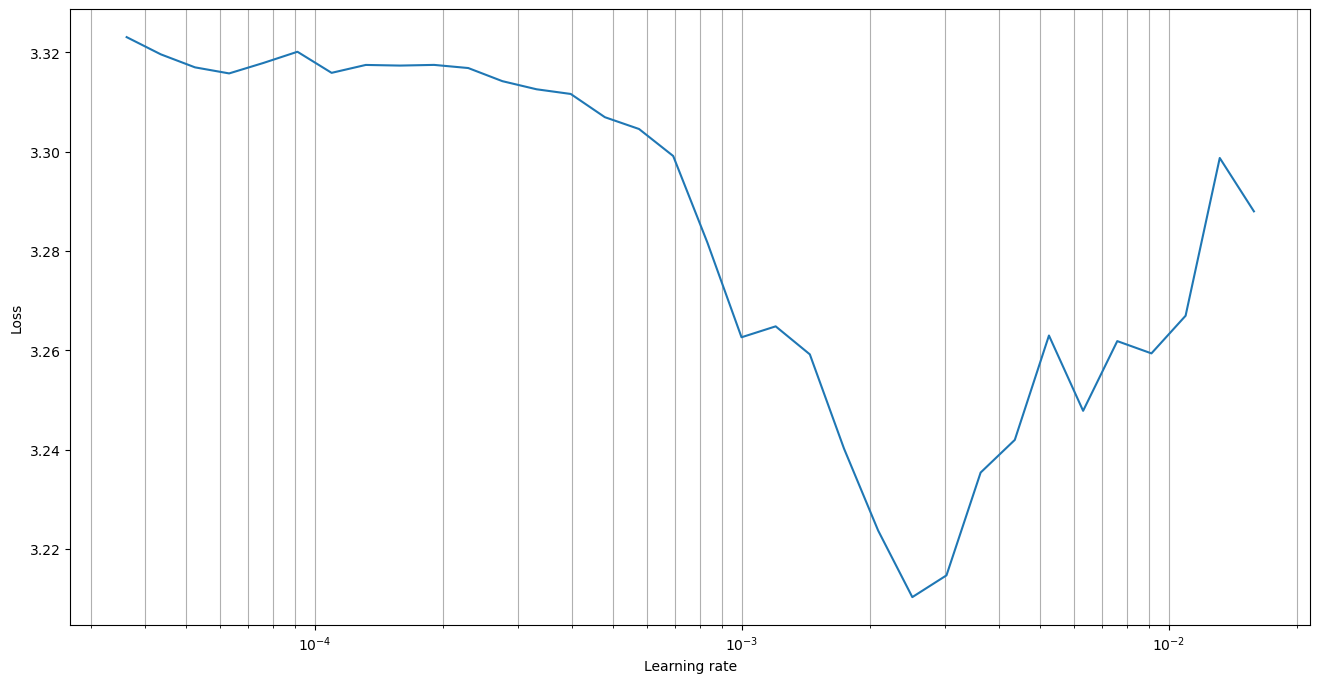

In [196]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

Good learning rate would be middle of the steepest downward curve. Here it would be 1*10^-4

In [197]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [198]:
EPOCHS = 5
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [199]:
def calculate_topk_accuracy(y_pred, y, k = 3):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [200]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [201]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [202]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [203]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut-crop-rs50-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @3: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @3: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 10s
	Train Loss: 2.294 | Train Acc @1:  34.63% | Train Acc @3:  56.09%
	Valid Loss: 1.409 | Valid Acc @1:  57.33% | Valid Acc @3:  80.86%
Epoch: 02 | Epoch Time: 2m 10s
	Train Loss: 1.420 | Train Acc @1:  56.70% | Train Acc @3:  80.12%
	Valid Loss: 1.209 | Valid Acc @1:  63.52% | Valid Acc @3:  87.56%
Epoch: 03 | Epoch Time: 2m 10s
	Train Loss: 0.970 | Train Acc @1:  69.64% | Train Acc @3:  89.11%
	Valid Loss: 0.985 | Valid Acc @1:  69.52% | Valid Acc @3:  89.50%
Epoch: 04 | Epoch Time: 2m 10s
	Train Loss: 0.529 | Train Acc @1:  83.33% | Train Acc @3:  95.81%
	Valid Loss: 0.820 | Valid Acc @1:  74.68% | Valid Acc @3:  91.56%
Epoch: 05 | Epoch Time: 2m 10s
	Train Loss: 0.235 | Train Acc @1:  93.32% | Train Acc @3:  98.79%
	Valid Loss: 0.834 | Valid Acc @1:  74.61% | Valid Acc @3:  91.62%


In [204]:
model.load_state_dict(torch.load('tut-crop-rs50-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @3: {test_acc_5*100:6.2f}%')

Test Loss: 6.097 | Test Acc @1:  38.65% | Test Acc @3:  57.27%


In [ ]:
# Training
# def train_model(model, criterion, optimizer, scheduler, epochs=EPOCHS):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     loss_train_idx = 0
#     loss_test_idx = 0

#     patience = PATIENCE

#     for epoch in range(epochs):
#         print(f'Epoch {epoch}/{epochs - 1}')
#         print('-' * 10)
  
#         # Iterate over the DataLoader for training data
#         for i, data in enumerate(dataloaders['train'], 0):
      
#         # Get inputs
#             inputs, targets = data
#             inputs = inputs.to(device)

#             # Write the network graph at epoch 0, batch 0
#             if epoch == 0 and i == 0:
#                 writer.add_graph(model, input_to_model=data[0].to(device), verbose=False)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'test']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#                 if phase == 'train':
#                     writer.add_scalar('Running_Loss/Train', running_loss, loss_train_idx)
#                     loss_train_idx += 1
#                 else:
#                     writer.add_scalar('Running_Loss/Test', running_loss, loss_test_idx)
#                     loss_test_idx += 1
          
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             if phase == 'train':
#                 writer.add_scalar('Loss/Train', epoch_loss, epoch)
#                 writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
#             else:
#                 writer.add_scalar('Loss/Test', epoch_loss, epoch)
#                 writer.add_scalar('Accuracy/Test', epoch_acc, epoch)

#             # deep copy the model
#             if phase == 'test':
#                 if epoch_acc > best_acc:
#                     patience = PATIENCE
#                     best_acc = epoch_acc
#                     best_model_wts = copy.deepcopy(model.state_dict())
#                 else:
#                     patience -= 1

#         # early stopping
#         if patience == 0:
#             print("Early stopping")
#             break

#         print()

#     writer.close()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best Test Acc: {best_acc:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
# Visualize Predictions
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['test']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             print(preds)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title(f'predicted: {class_names[preds[j]]}')
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [ ]:
# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 5 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
# # Training
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        epochs=EPOCHS)

In [ ]:
# %load_ext tensorboard


In [ ]:
# %tensorboard --logdir="runs/plant_leaves"

In [ ]:
# visualize_model(model_ft)

In [205]:
# Grad-CAM
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=80a18b3617820265ec4652f7c7ad3fa26454aba3673a619d3cc3a47bb948d950
  Stored in directory: /root/.cache/pip/wheels/30/aa/c4/88d65c539f7e1dc61296ec47f9870081146be6bcab6698e6a5
Successfully built grad-cam


In [206]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import cv2
from PIL import Image

In [207]:
images_for_cam = [
    "/kaggle/input/cropped-bg/croppedbg/Train/Apple Scab Leaf/1393scab_on_leaf.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Train/Blueberry leaf/1154Blueberry07.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Train/Corn Gray leaf spot/1355Fig_202b._20GLS_20backlit_20copy.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Train/Peach leaf/104222+August+2013+008-1.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Train/Potato leaf early blight/1299potato-blight-phytophthora-infestans-close-up-of-upper-surface-of-bmmrxd.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Train/Tomato mold leaf/1817Leaf+Mold+lower+leaf+surface+spores+_28conidia_29.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Test/Corn leaf blight/339Corn-SCLB-2017-1.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Test/Bell_pepper leaf spot/28CMVpepperLeafShock-copy-50QUALITY-1ge8umw.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Test/Strawberry leaf/143strawberry-leaves-isolated-white-34722259.jpg",
    "/kaggle/input/cropped-bg/croppedbg/Test/Tomato leaf mosaic virus/296ill-tomato-of-tomato-mosaic-virus-DBE17N.jpg"
]

In [208]:
rgb_imgs = []
input = []
transform = transforms.Resize((IMG_SIZE,IMG_SIZE))
for i in range(len(images_for_cam)):

  rgb_imgs.append(cv2.imread(images_for_cam[i]))
  rgb_imgs[i] = (Image.open(images_for_cam[i]))
  rgb_imgs[i] = transform(rgb_imgs[i])
  rgb_imgs[i] = (np.float32(rgb_imgs[i]) / 255)

  input.append(preprocess_image(rgb_imgs[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
  input[i] = input[i].to(device)


In [210]:

target_layers = [last_conv_layer]

# input_tensor = input_tensor # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam_g = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
cam_gp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
cam_s = ScoreCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())


In [211]:
torch.cuda.empty_cache()


In [ ]:
f, ax = plt.subplots(len(images_for_cam),4, figsize=(12,30))
for i in range(len(images_for_cam)):
    grayscale_cam_g = cam_g(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_g = grayscale_cam_g[0, :]
    visualization_g = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    grayscale_cam_gp = cam_gp(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_gp = grayscale_cam_gp[0, :]
    visualization_gp = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    grayscale_cam_s = cam_s(input_tensor=input[i], targets=None, aug_smooth=True, eigen_smooth=True)
    grayscale_cam_s = grayscale_cam_s[0, :]
    visualization_s = show_cam_on_image(rgb_imgs[i], grayscale_cam_g, use_rgb=True)

    ax[i][0].imshow(rgb_imgs[i])
    ax[i][1].imshow(visualization_g)
    ax[i][2].imshow(visualization_gp)
    ax[i][3].imshow(visualization_s)

 16%|█▌        | 20/128 [00:31<09:58,  5.54s/it]

**Test on Plant Village Dataset**